In [1]:
import pandas as pd
import numpy as np
import os
import pickle
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from scipy.sparse import hstack
import re



In [2]:
df = pd.read_csv("../enron_1.csv")

In [35]:
# 1. Check for NaNs in the processed text
num_nans = df['final_text'].isnull().sum()
print("NaNs in final_text:", num_nans)

# 2. Check for empty strings (after stripping whitespace)
num_empty = (df['final_text'].str.strip() == '').sum()
print("Empty strings in final_text:", num_empty)


NaNs in final_text: 0
Empty strings in final_text: 0


### Split Data into Train/Test

In [33]:
df = df.dropna(subset=['final_text']) # Drop rows that are NaN
df = df.reset_index(drop=True)


In [36]:
print(df.isnull().sum())


is_spam                 0
final_text              0
word_count              0
char_count              0
avg_word_length         0
num_count               0
punct_count             0
rare_word_count         0
has_rare_word           0
many_rare_words         0
avg_word_length_high    0
dtype: int64


In [37]:
X = df['final_text']  # preprocessed email text
y = df['is_spam']     # labels: 0 = ham, 1 = spam

X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.2,       # 20% of data for testing
    random_state=42,     # ensures reproducibility
    stratify=y           # preserves the spam/ham ratio in train/test
)


In [10]:
print(f"Train size: {len(X_train)}, Test size: {len(X_test)}")
print("\nTrain label distribution:")
print(y_train.value_counts(normalize=True))
print("\nTest label distribution:")
print(y_test.value_counts(normalize=True))


Train size: 23493, Test size: 5874

Train label distribution:
is_spam
0    0.526838
1    0.473162
Name: proportion, dtype: float64

Test label distribution:
is_spam
0    0.526898
1    0.473102
Name: proportion, dtype: float64


## Data Engineering/Extraction

### TF-IDF Vectorization

In [11]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf = TfidfVectorizer(
    max_features=5000,    # limit vocabulary size, 5000 features (these features are the most “important” words or n-grams from our corpus)
    ngram_range=(1, 2),   # unigrams + bigrams
    stop_words='english'  # skip common words
)

X_tfidf = tfidf.fit_transform(df['final_text'].dropna()) #feature matrix, the numerical representation of all our documents


TF-IDF extracts each unique word (or n-gram), builds a vocabulary

Builds/returns a vocabulary of all unique words (or n-grams) it learned from your corpus. Above shows only the words that actually appear in the first email, along with their importance scores.

### Inspect / Analyze TF-IDF

In [14]:
vocab = tfidf.get_feature_names_out()
print(len(vocab))        # should be ≤ max_features
print(vocab[:20])        # preview first 20 words

5000
['00' '00 00' '00 10' '00 60' '00 90' '00 million' '00 pm' '000' '000 00'
 '000 000' '000 enron' '000 hpl' '000 mmbtu' '0000' '001' '01' '01 01'
 '01 2000' '01 2001' '01 enron']


In [15]:
# View words specifically 
word_vocab = [w for w in vocab if re.match(r'^[a-zA-Z]+$', w)]
print(f"Words only: {len(word_vocab)}")
print(word_vocab[:50])  # preview first 50 words


Words only: 3439
['aa', 'ab', 'ability', 'able', 'abroad', 'absence', 'absolutely', 'abuse', 'ac', 'academic', 'accept', 'acceptable', 'acceptance', 'accepted', 'access', 'accessory', 'accomplish', 'accordance', 'according', 'accordingly', 'account', 'accountant', 'accounting', 'accuracy', 'accurate', 'achieve', 'achievement', 'acquire', 'acquired', 'acquiring', 'acquisition', 'acre', 'acrobat', 'act', 'action', 'active', 'activity', 'actua', 'actual', 'actually', 'acy', 'ad', 'adam', 'add', 'added', 'adding', 'addition', 'additiona', 'additional', 'additionally']


Above checks TF-IDF vocabulary

In [16]:
i = 0  # first email
df_single = pd.DataFrame(X_tfidf[i].T.todense(), index=tfidf.get_feature_names_out(), columns=["tfidf"])
print(df_single[df_single.tfidf > 0]) #Filter to only non-zero TF-IDF scores


            tfidf
04       0.035158
05       0.071669
07       0.038055
08       0.036016
08 2000  0.058075
...           ...
update   0.038464
utility  0.091919
volume   0.037544
waiting  0.047460
working  0.035259

[149 rows x 1 columns]


In [17]:
sparsity = 1.0 - (X_tfidf.count_nonzero() / (X_tfidf.shape[0] * X_tfidf.shape[1]))
print(f"Sparsity: {sparsity:.2%}")


Sparsity: 98.63%


Out of all the entries in your TF-IDF matrix, 98.62% are zeros.
Only 1.38% of the cells have a non-zero TF-IDF value.

### top words by TF-IDF score

In [19]:
# tfidf (TfidfVectorizer) and X_tfidf assumed present
feature_names = tfidf.get_feature_names_out()
tfidf_df = pd.DataFrame(X_tfidf.toarray(), columns=feature_names)

# average TF-IDF in spam vs non-spam
avg_spam = tfidf_df[df['is_spam'] == 1].mean(axis=0)
avg_nonspam = tfidf_df[df['is_spam'] == 0].mean(axis=0)

spam_top = avg_spam.sort_values(ascending=False).head(40)
print("Top TF-IDF words in spam (avg):")
print(spam_top)


Top TF-IDF words in spam (avg):
http           0.036147
com            0.033903
email          0.021875
www            0.020625
company        0.019221
click          0.018814
http www       0.017135
price          0.016159
software       0.015285
money          0.015048
offer          0.015029
free           0.014884
best           0.014865
site           0.014767
save           0.014642
time           0.014352
online         0.014208
want           0.013690
order          0.013216
info           0.013026
day            0.012880
new            0.012586
business       0.012561
information    0.012507
net            0.012393
like           0.012305
account        0.012030
000            0.011856
product        0.011829
mail           0.011767
need           0.011578
website        0.011016
life           0.010767
visit          0.010753
stop           0.010666
adobe          0.010446
make           0.010431
message        0.010377
hello          0.009895
viagra         0.009871
dtype: f

## Additional features (to test)

- Common keywords
- word count
- char count 
- Avg word length
- number frequency 
- punctuation frequency 

### Exploring common phishing keywords

In [ ]:
key_words = [
    'verify', 'account', 'click', 'login', 'password',
    'bank', 'transfer', 'free', 'win', 'payment', 'transaction', 'transfer', 'money', 'tax', 'receipt', 'billing', 
    'urgent'
]

# Dictionary to hold keyword summary
kw_summary = {}

# Loop through each keyword
for w in key_words:
    # Detect presence of keyword (boolean Series, not added to df)
    has_kw = df['final_text'].str.contains(r'\b' + re.escape(w) + r'\b', regex=True, case=False)
    
    # Compute metrics
    tp = ((has_kw) & (df['is_spam'] == 1)).sum()  # spam emails containing keyword
    fp = ((has_kw) & (df['is_spam'] == 0)).sum()  # non-spam emails containing keyword
    in_email = has_kw.sum()                       # total emails containing keyword

    # Store in summary
    kw_summary[w] = {
        'in_email': in_email,
        'spam_hits': tp,
        'nonspam_hits': fp,
        'spam_likelihood': tp / (in_email + 1e-9)
    }

# Convert to DataFrame for viewing
kw_df = pd.DataFrame.from_dict(kw_summary, orient='index').sort_values('spam_likelihood', ascending=False)
kw_df

,in_email,spam_hits,nonspam_hits,spam_likelihood
money,2557,2116,441,0.827532
click,2549,2020,529,0.792468
irs,26,18,8,0.692308
account,1794,1230,564,0.685619
1099,3,2,1,0.666667
bank,1088,722,366,0.663603
transfer,846,558,288,0.659574
free,2938,1903,1035,0.647720
win,256,155,101,0.605469
receipt,566,331,235,0.584806


In [ ]:
df['word_count'] = df['final_text'].apply(lambda x: len(str(x).split()))
df['char_count'] = df['final_text'].apply(lambda x: len(str(x)))
df['avg_word_length'] = df['final_text'].apply(lambda x: np.mean([len(w) for w in str(x).split()]) if len(str(x).split()) > 0 else 0)

def count_numbers(text):
    return len(re.findall(r'\d+', text))

df['num_count'] = df['final_text'].apply(count_numbers)


import string

def count_punctuation(text):
    return sum(1 for char in text if char in string.punctuation)

df['punct_count'] = df['final_text'].apply(count_punctuation)

In [22]:
df.sample(10)

,is_spam,final_text,word_count,char_count,avg_word_length,num_count,punct_count
3429,1,doctor visit needed . remove . back ' tiny lot...,35,158,3.542857,0,12
10921,0,"hi louise , hope going well ! please advise : ...",50,300,5.020000,1,12
27661,1,snip mesquite trail eucre locate prescription ...,28,196,6.035714,0,4
10439,0,"louise , attached board presentation . please ...",22,120,4.500000,2,6
2836,0,"anita , speaking gary lamphier , big thicket '...",124,717,4.790323,7,33
28776,1,"banque international du burkina , avenue dimdo...",344,2152,5.258721,10,61
5919,0,"shmuel , let ' see either rearrange seminar sp...",1170,4285,2.663248,79,742
16988,0,start date : 12 / 15 / 01 ; hourahead hour : 1...,46,221,3.826087,5,20
8699,0,automatic confirmation order placed using cent...,47,317,5.765957,1,10
8624,0,automatic confirmation request placed using ce...,45,242,4.400000,4,13


### Unsual/rare word feature 
- signal for unusual or suspicious words

In [48]:
from collections import Counter

# join all words in the corpus into huge string
all_words = " ".join(df['final_text']).split()  # Use your cleaned text column

# Count the frequency of each word
word_counts = Counter(all_words)

# Define and store rare words (appearing < n times across your entire corpus) 
rare_words = {w for w, c in word_counts.items() if c < 4}

# Function to count rare words per email
def count_rare_words(text):
    return sum(1 for w in str(text).split() if w in rare_words)

df['rare_word_count'] = df['final_text'].apply(count_rare_words)


In [49]:
df.sample(5)

,is_spam,final_text,word_count,char_count,avg_word_length,num_count,punct_count,rare_word_count,has_rare_word,many_rare_words,avg_word_length_high
20144,1,. . two zenith walk betel one pick allotted . ...,84,419,4.000000,0,46,2,1,0,0
17682,1,unsubscribe receiving future e - mail message ...,117,587,4.025641,11,35,1,1,0,0
1780,0,jackie - life remember sale deal . believe val...,59,319,4.423729,0,16,0,0,0,1
17544,1,short little form provide great rate improve l...,162,909,4.617284,8,48,0,0,1,1
20885,0,sally - thanks . bring picture come houston ! ...,124,660,4.330645,7,29,1,0,0,1


### Rare word feature

In [50]:
df['has_rare_word'] = (df['rare_word_count'] > 0).astype(int)

# Step 2: Group by spam label and calculate counts and percentages
summary = df.groupby('is_spam')['has_rare_word'].agg(
    total_emails='count',
    emails_with_rare_words='sum'
)

# Step 3: Add percentage column
summary['percentage_with_rare_words'] = (
    summary['emails_with_rare_words'] / summary['total_emails'] * 100
)

# Step 4: Display the summary
print(summary)

         total_emails  emails_with_rare_words  percentage_with_rare_words
is_spam                                                                  
0               15472                    8538                   55.183557
1               13895                   10368                   74.616769


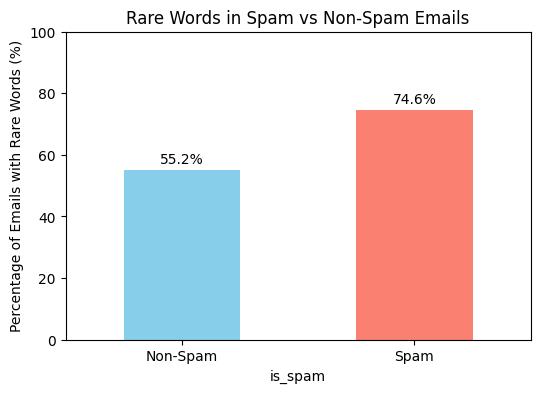

In [51]:
import matplotlib.pyplot as plt

# Use the summary you already created
percentages = summary['percentage_with_rare_words']

# Bar chart
plt.figure(figsize=(6,4))
percentages.plot(kind='bar', color=['skyblue','salmon'])
plt.xticks([0,1], ['Non-Spam', 'Spam'], rotation=0)
plt.ylabel('Percentage of Emails with Rare Words (%)')
plt.title('Rare Words in Spam vs Non-Spam Emails')
plt.ylim(0,100)

# Add value labels on top of bars
for i, val in enumerate(percentages):
    plt.text(i, val + 2, f'{val:.1f}%', ha='center')

plt.show()


### Exploring emails with specific rare word under a condition
- number of rare words

In [27]:
threshold = 4
df['many_rare_words'] = (df['rare_word_count'] >= threshold).astype(int)

# Result: a summary DataFrame showing counts for spam vs non-spam.
summary = df.groupby('is_spam')['many_rare_words'].agg(
    total_emails='count',
    emails_with_many_rare_words='sum'
)

# compute %
summary['percentage_with_many_rare_words'] = (
    summary['emails_with_many_rare_words'] / summary['total_emails'] * 100
)

summary.head()

,total_emails,emails_with_many_rare_words,percentage_with_many_rare_words
is_spam,,,
0,15472,2916,18.846949
1,13895,6164,44.361281


- Non-spam emails: only ~15% contain many rare words.
- Spam emails: ~42% contain many rare words — almost 3x higher than non-spam

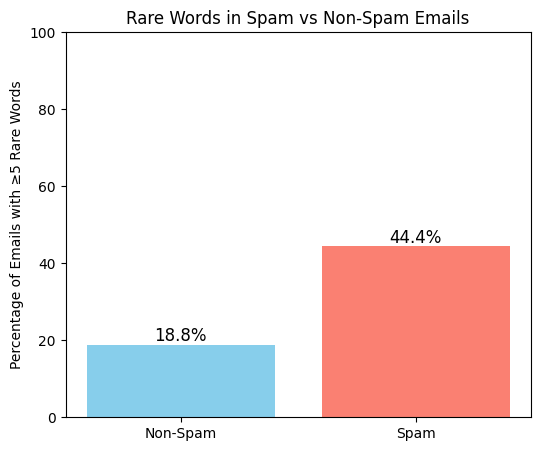

In [28]:
import matplotlib.pyplot as plt

# Use your summary dataframe
percentages = summary['percentage_with_many_rare_words']

plt.figure(figsize=(6,5))
bars = plt.bar(['Non-Spam', 'Spam'], percentages, color=['skyblue','salmon'])

# Add value labels on top of bars
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, height + 1, f'{height:.1f}%', ha='center', fontsize=12)

plt.ylim(0, 100)
plt.ylabel('Percentage of Emails with ≥5 Rare Words')
plt.title('Rare Words in Spam vs Non-Spam Emails')
plt.show()


### Explore average word len in norm vs. spam

In [29]:
# For simplicity, split at the median
median_length = df['avg_word_length'].median()
df['avg_word_length_high'] = (df['avg_word_length'] >= median_length).astype(int)



In [30]:
summary_length = df.groupby('avg_word_length_high')['is_spam'].agg(
    total_emails='count',
    spam_emails='sum'
)

summary_length['percentage_spam'] = summary_length['spam_emails'] / summary_length['total_emails'] * 100
print(summary_length)


                      total_emails  spam_emails  percentage_spam
avg_word_length_high                                            
0                            14680         5942        40.476839
1                            14687         7953        54.149929


- There is a higher percentage of spam emails containing longer words